# Calibrating MESMER on multiple scenarios
This tutorial shows how to calibrate the parameters for MESMER on an example dataset of coarse regridded ESM output for multiple climate change scenarios. We calibrate the parameters for MESMER using three scenarios: a historical, a low emission (SSP1-2.6), and a high emission (SSP5-8.5) scenario, with SSP5-8.5 including several ensemble members. Training MESMER consists of four parts:

- **global trend**: compute the global temperature trend, including the volcanic influence on historical trends
- **global variablity**: estimating the parameters to generate global variability
- **local trend**: estimate parameters to translate global mean temperature (including global variability) into locally resolved temperature
- **local variability**: estimate parameters needed to generate local variability

You can find the basics of the MESMER approach in [Beusch et al. 2020](https://doi.org/10.5194/ESD-11-139-2020) and the multi-sceario approach in [Beusch et al. 2022](https://doi.org/10.5194/gmd-15-2085-2022).

In [1]:
{
    "tags": [
        "remove-cell",
        "remove-output"
    ]
}

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pathlib

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from filefisher import FileFinder

import mesmer
from mesmer.core.datatree import map_over_datasets

### Load data

MEMSER expects a specific data format. Data from each scenario should be a node (or group) on an `xr.DataTree` (more on this below) e.g.:

```
<xarray.DataTree>
Group: /
├── Group: /historical
|    ...
├── Group: /ssp126
|    ...
```

Each node should be `xr.Dataset` with 4 dimensions: member, time, lat, lon. Below we show one way to load data such that it conforms to the desired format. We load data from the cmip6-ng ("new generation") repository. This data has undergone a small reformatting from the original cmip6 archive. For the sake of computational speed we also load data which has been regridded to a coarse resolution. Loading the data can be adapted to the data format you are most used to - as long as the final output has the desired format.

---

MESMER is Earth System Model specific, aiming to reproduce to some extent the behaviour of one ESM. Here we train on the CMIP6 output of the model IPSL-CM6A-LR.

In [3]:
model = "IPSL-CM6A-LR"

We use the library [filefisher](https://github.com/mpytools/filefisher) to search all files in the cmip6-ng archive for the model and scenarios we want to use. Filefisher can search through paths for given certain file patterns. It returns all paths matching the pattern such that you can load the files in the next step.

Here, we want to find all files that have data for annual near surface temperature (tas) for the used model and the future scenarios ssp126 and ssp585. Next, we search for the historical data that match the members found for the two future scenarios.

In [4]:
# mesmer provides example data under "data/cmip6-ng"
cmip_data_path = mesmer.example_data.cmip6_ng_path()

CMIP_FILEFINDER = FileFinder(
    path_pattern=cmip_data_path / "{variable}/{time_res}/{resolution}",
    file_pattern="{variable}_{time_res}_{model}_{scenario}_{member}_{resolution}.nc",
)
CMIP_FILEFINDER

<FileFinder>
path_pattern: '/Users/vbauer/Developer/mesmer/data/cmip6-ng/{variable}/{time_res}/{resolution}/'
file_pattern: '{variable}_{time_res}_{model}_{scenario}_{member}_{resolution}.nc'

keys: 'member', 'model', 'resolution', 'scenario', 'time_res', 'variable'

Search data for ssp126 and ssp585 - we find one and two ensemble members, respectively:

In [5]:
scenarios = ["ssp126", "ssp585"]

fc_scens = CMIP_FILEFINDER.find_files(
    variable="tas", scenario=scenarios, model=model, resolution="g025", time_res="ann"
)

fc_scens.df

,variable,time_res,resolution,model,scenario,member
path,,,,,,
/Users/vbauer/Developer/mesmer/data/cmip6-ng/tas/ann/g025/tas_ann_IPSL-CM6A-LR_ssp126_r1i1p1f1_g025.nc,tas,ann,g025,IPSL-CM6A-LR,ssp126,r1i1p1f1
/Users/vbauer/Developer/mesmer/data/cmip6-ng/tas/ann/g025/tas_ann_IPSL-CM6A-LR_ssp585_r1i1p1f1_g025.nc,tas,ann,g025,IPSL-CM6A-LR,ssp585,r1i1p1f1
/Users/vbauer/Developer/mesmer/data/cmip6-ng/tas/ann/g025/tas_ann_IPSL-CM6A-LR_ssp585_r2i1p1f1_g025.nc,tas,ann,g025,IPSL-CM6A-LR,ssp585,r2i1p1f1


We also need to find the same ensemble members in the historical data, such that we end with five files we need to load:

In [6]:
# get the historical members that are also in the future scenarios, but only once
members = fc_scens.df.member.unique()

fc_hist = CMIP_FILEFINDER.find_files(
    variable="tas",
    scenario="historical",
    model=model,
    resolution="g025",
    time_res="ann",
    member=members,
)

fc_all = fc_hist.concat(fc_scens)
fc_all.df

,variable,time_res,resolution,model,scenario,member
path,,,,,,
/Users/vbauer/Developer/mesmer/data/cmip6-ng/tas/ann/g025/tas_ann_IPSL-CM6A-LR_historical_r1i1p1f1_g025.nc,tas,ann,g025,IPSL-CM6A-LR,historical,r1i1p1f1
/Users/vbauer/Developer/mesmer/data/cmip6-ng/tas/ann/g025/tas_ann_IPSL-CM6A-LR_historical_r2i1p1f1_g025.nc,tas,ann,g025,IPSL-CM6A-LR,historical,r2i1p1f1
/Users/vbauer/Developer/mesmer/data/cmip6-ng/tas/ann/g025/tas_ann_IPSL-CM6A-LR_ssp126_r1i1p1f1_g025.nc,tas,ann,g025,IPSL-CM6A-LR,ssp126,r1i1p1f1
/Users/vbauer/Developer/mesmer/data/cmip6-ng/tas/ann/g025/tas_ann_IPSL-CM6A-LR_ssp585_r1i1p1f1_g025.nc,tas,ann,g025,IPSL-CM6A-LR,ssp585,r1i1p1f1
/Users/vbauer/Developer/mesmer/data/cmip6-ng/tas/ann/g025/tas_ann_IPSL-CM6A-LR_ssp585_r2i1p1f1_g025.nc,tas,ann,g025,IPSL-CM6A-LR,ssp585,r2i1p1f1


Now we load all the files we found into a ``DataTree``. ``DataTree`` is a data structure provided by [xarray](https://docs.xarray.dev/en/stable/index.html).

Essentially, ``DataTree`` is a container to hold xarray `Dataset` with data variables that are not alignable. This is useful for us since we have historical and future data, which have different time coordinates. Moreover, the scenarios may also have different numbers of members (as e.g., ssp126, which only has one). Thus, we store the data of each sceanrio in a `xarray.Dataset` holding all its ensemble members along a `member` dimension. Then we store all the scenario datasets in one `DataTree`. The `DataTree` allows us to perform computations on each of the datasets in a readable way.

In [7]:
dt = xr.DataTree()

scenarios_incl_hist = ["historical"] + scenarios

time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)

# load data for each scenario
for scen in scenarios_incl_hist:
    files = fc_all.search(scenario=scen)

    # load all members for a scenario
    members = []
    for fN, meta in files.items():
        ds = xr.open_dataset(fN, decode_times=time_coder)
        # drop unnecessary variables
        ds = ds.drop_vars(["height", "time_bnds", "file_qf"], errors="ignore")
        # assign member-ID as coordinate
        ds = ds.assign_coords({"member": meta["member"]})
        members.append(ds)

    # create a Dataset that holds each member along the member dimension
    scen_data = xr.concat(members, dim="member")
    # put the scenario dataset into the DataTree
    dt[scen] = xr.DataTree(scen_data)

dt

<xarray.DataTree>
Group: /
├── Group: /historical
│       Dimensions:  (member: 2, time: 165, lat: 20, lon: 20)
│       Coordinates:
│         * time     (time) object 1kB 1850-07-01 06:00:00 ... 2014-07-01 06:00:00
│         * lon      (lon) float64 160B 0.0 18.0 36.0 54.0 ... 288.0 306.0 324.0 342.0
│         * lat      (lat) float64 160B -85.5 -76.5 -67.5 -58.5 ... 58.5 67.5 76.5 85.5
│         * member   (member) <U8 64B 'r1i1p1f1' 'r2i1p1f1'
│       Data variables:
│           tas      (member, time, lat, lon) float64 1MB 226.3 225.0 ... 258.4 259.6
│       Attributes: (12/56)
│           CDI:                       Climate Data Interface version 1.9.9 (https://...
│           source:                    IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; ...
│           institution:               Institut Pierre Simon Laplace, Paris 75252, Fr...
│           Conventions:               CF-1.7 CMIP-6.2
│           history:                   Thu Mar 18 19:05:09 2021: cdo remapbil,r20x20 ...
│           creation_date:             2018-07-11T07:36:34Z
│           ...                        ...
│           realization_index:         1
│           NCO:                       "4.6.0"
│           cmip6-ng:                  \ncontact = cmip6-archive@env.ethz.ch\ndescrip...
│           original_file_names:       /net/atmos/data/cmip6/historical/Amon/tas/IPSL...
│           original_file_hash_codes:  7264c228560257b32d44dcc611d92976da7214af7e8795...
│           CDO:                       Climate Data Operators version 1.9.9 (https://...
├── Group: /ssp126
│       Dimensions:  (member: 1, time: 86, lat: 20, lon: 20)
│       Coordinates:
│         * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│         * lon      (lon) float64 160B 0.0 18.0 36.0 54.0 ... 288.0 306.0 324.0 342.0
│         * lat      (lat) float64 160B -85.5 -76.5 -67.5 -58.5 ... 58.5 67.5 76.5 85.5
│         * member   (member) <U8 32B 'r1i1p1f1'
│       Data variables:
│           tas      (member, time, lat, lon) float64 275kB 227.7 226.1 ... 263.4 264.9
│       Attributes: (12/56)
│           CDI:                       Climate Data Interface version 1.9.9 (https://...
│           source:                    IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; ...
│           institution:               Institut Pierre Simon Laplace, Paris 75252, Fr...
│           Conventions:               CF-1.7 CMIP-6.2
│           history:                   Thu Mar 18 19:05:09 2021: cdo remapbil,r20x20 ...
│           name:                      /ccc/work/cont003/gencmip6/oboucher/IGCM_OUT/I...
│           ...                        ...
│           dr2xml_md5sum:             c2dce418e78ca835be1e2ff817c2c403
│           model_version:             6.1.8
│           cmip6-ng:                  \ncontact = cmip6-archive@env.ethz.ch\ndescrip...
│           original_file_names:       /net/atmos/data/cmip6/ssp126/Amon/tas/IPSL-CM6...
│           original_file_hash_codes:  8cfb5fd339c050bc81d2e2eeb7263ceec89c295d15631b...
│           CDO:                       Climate Data Operators version 1.9.9 (https://...
└── Group: /ssp585
        Dimensions:  (member: 2, time: 86, lat: 20, lon: 20)
        Coordinates:
          * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
          * lon      (lon) float64 160B 0.0 18.0 36.0 54.0 ... 288.0 306.0 324.0 342.0
          * lat      (lat) float64 160B -85.5 -76.5 -67.5 -58.5 ... 58.5 67.5 76.5 85.5
          * member   (member) <U8 64B 'r1i1p1f1' 'r2i1p1f1'
        Data variables:
            tas      (member, time, lat, lon) float64 550kB 226.4 225.0 ... 275.5 277.2
        Attributes: (12/56)
            CDI:                       Climate Data Interface version 2.1.0 (https://...
            source:                    IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; ...
            institution:               Institut Pierre Simon Laplace, Paris 75252, Fr...
            Conventions:               CF-1.7 CMIP-6.2
      

This results in the data format discussed above. You can examine it by clicking on `Groups` above. 

---

We will need some configuration parameters in the follwing:
1. ``THRESHOLD_LAND``: Threshold above which land fraction to consider a grid point as a land grid point.
2. ``REFERENCE_PERIOD``: We will work not with absolute temperature values but with temperature anomalies w.r.t. a reference period

In [8]:
THRESHOLD_LAND = 1 / 3
REFERENCE_PERIOD = slice("1850", "1900")

### Calculate anomalies

In [9]:
# calculate anomalies w.r.t. the reference period
tas_anom = mesmer.anomaly.calc_anomaly(dt, reference_period=REFERENCE_PERIOD)

### Volcanic contributions
The volcanic contributions to the global mean temperature trend of the historical period have to be removed in order to estimate the linear regression of global mean temperature to local temperature.

1. Calculate global mean and smooth the forcing data using a lowess smoother, using 50 time steps. 

In [10]:
# calculate global mean
tas_globmean = mesmer.weighted.global_mean(tas_anom)
tas_globmean

<xarray.DataTree>
Group: /
├── Group: /historical
│       Dimensions:  (time: 165, member: 2)
│       Coordinates:
│         * time     (time) object 1kB 1850-07-01 06:00:00 ... 2014-07-01 06:00:00
│         * member   (member) <U8 64B 'r1i1p1f1' 'r2i1p1f1'
│       Data variables:
│           tas      (member, time) float64 3kB -0.2154 -0.04608 ... 1.388 1.362
├── Group: /ssp126
│       Dimensions:  (time: 86, member: 1)
│       Coordinates:
│         * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│         * member   (member) <U8 32B 'r1i1p1f1'
│       Data variables:
│           tas      (member, time) float64 688B 1.228 1.327 1.554 ... 2.436 2.473 2.328
└── Group: /ssp585
        Dimensions:  (time: 86, member: 2)
        Coordinates:
          * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
          * member   (member) <U8 64B 'r1i1p1f1' 'r2i1p1f1'
        Data variables:
            tas      (member, time) float64 1kB 1.336 1.666 1.791 ... 6.469 6.671 6.925

In [11]:
# mean over members before smoothing
tas_globmean_ensmean = tas_globmean.mean(dim="member")

n_steps = 50

tas_globmean_smoothed = mesmer.stats.lowess(
    tas_globmean_ensmean,
    dim="time",
    n_steps=n_steps,
    use_coords=False,
)

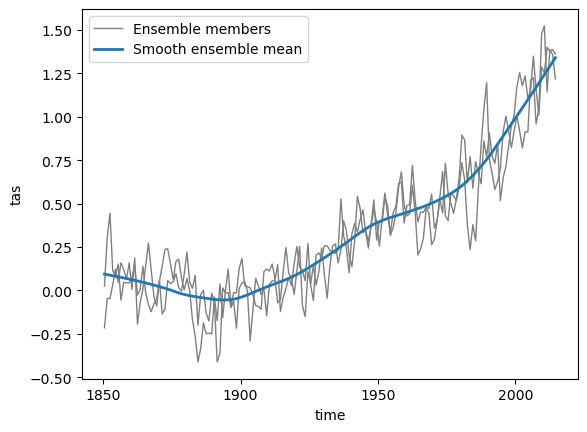

In [12]:
# plot historical
f, ax = plt.subplots()

h0, *_ = tas_globmean["historical"].tas.plot.line(ax=ax, x="time", color="grey", lw=1)
a2, *_ = tas_globmean_smoothed["historical"].tas.plot.line(ax=ax, x="time", lw=2)

ax.legend([h0, a2], ["Ensemble members", "Smooth ensemble mean"])

2. Fit the parameter of the volcanic contributions only on the historical smoothed data of all ensemble members available. The future scenarios do not have volcanic contributions.

In [13]:
hist_tas_residuals = tas_globmean["historical"] - tas_globmean_smoothed["historical"]

# fit volcanic influence
volcanic_params = mesmer.volc.fit_volcanic_influence(hist_tas_residuals.tas)

volcanic_params.aod

<xarray.DataArray 'aod' ()> Size: 8B
array(-1.75209374)

3. Superimpose the volcanic influence on the historical time series. Note that due to the approach to handle the historical data as its own scenario, we ecounter discontinuities at the boundary between historical and future period. However, this is not relevant for the fitting of the parameters hereafter.

In [14]:
# superimpose the volcanic forcing on historical data
tas_globmean_smoothed["historical"] = mesmer.volc.superimpose_volcanic_influence(
    tas_globmean_smoothed["historical"],
    volcanic_params,
)

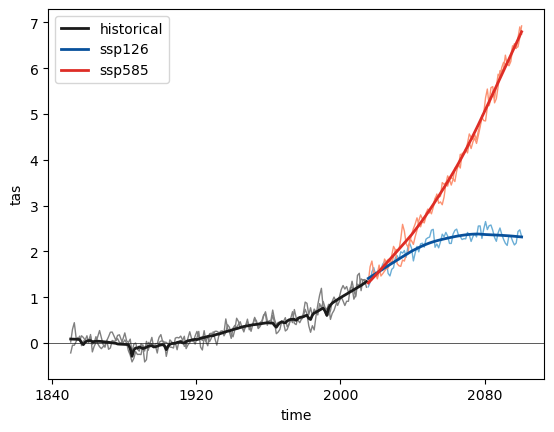

In [15]:
# some plotting
f, ax = plt.subplots()

# plot unsmoothed global means
tas_globmean["historical"].tas.plot.line(
    ax=ax, lw=1, x="time", color="0.5", add_legend=False
)
tas_globmean["ssp126"].tas.plot.line(
    ax=ax, lw=1, x="time", color="#6baed6", add_legend=False
)
tas_globmean["ssp585"].tas.plot.line(
    ax=ax, lw=1, x="time", color="#fc9272", add_legend=False
)

# plot smoothed global means including volcanic influence for historical
tas_globmean_smoothed["historical"].tas.plot.line(
    ax=ax, lw=2, x="time", color="0.1", label="historical"
)
tas_globmean_smoothed["ssp126"].tas.plot.line(
    ax=ax, lw=2, x="time", color="#08519c", label="ssp126"
)
tas_globmean_smoothed["ssp585"].tas.plot.line(
    ax=ax, lw=2, x="time", color="#de2d26", label="ssp585"
)


# histend = tas_globmean["historical"].time.isel(time=-1).item()
# ax.axvline(histend, color="0.4")
ax.axhline(0, color="0.1", lw=0.5)

ax.set_title("")
plt.legend(loc="upper left")

4. Calculate residuals (w.r.t. smoothed ts) i.e. remove the smoothed global mean, including the volcanic influence from the anomalies.

In [16]:
tas_globmean_resids = tas_globmean - tas_globmean_smoothed
# rename to tas_resids
tas_globmean_resids = map_over_datasets(
        lambda ds: ds.rename({"tas": "tas_resids"}), tas_globmean_resids
    )

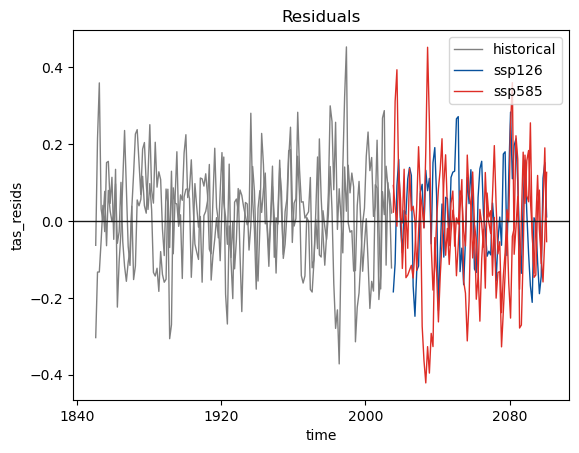

In [17]:
# plot residuals
h0, *_ = tas_globmean_resids["historical"].tas_resids.plot.line(
    x="time", color="0.5", lw=1, add_legend=False
)
h1, *_ = tas_globmean_resids["ssp126"].tas_resids.plot.line(
    x="time", color="#08519c", lw=1, add_legend=False
)
h2, *_ = tas_globmean_resids["ssp585"].tas_resids.plot.line(
    x="time", color="#de2d26", lw=1, add_legend=False
)


plt.title("Residuals")
plt.axhline(0, lw=1, color="0.1")

plt.legend([h0, h1, h2], ["historical", "ssp126", "ssp585"])
plt.show()
# TODO add legend for the scenarios

### Global variability

In this step we want to fit an AR process for estimating global variability, taking in the residual global mean temperature as follows:

$T_{t}^{glob, var} = \alpha_0 + \sum\limits_{k=1}^{k=p} \alpha_k \cdot T_{t-k}^{glob, var} + \varepsilon_t,\ \varepsilon_t \sim \mathcal{N}(0, \sigma)$

We first estimate the order of the AR process and then fit the parameters. Internally, we fit the parameters for each member and then average first over the parameters of each scenario and then over all scenarios to arrive at a single set of parameters.

In [18]:
ar_order = mesmer.stats.select_ar_order_scen_ens(
    tas_globmean_resids, dim="time", ens_dim="member", maxlag=12, ic="bic"
)

global_ar_params = mesmer.stats.fit_auto_regression_scen_ens(
    tas_globmean_resids, dim="time", ens_dim="member", lags=ar_order
)

global_ar_params = global_ar_params.drop_vars("nobs")
global_ar_params

<xarray.Dataset> Size: 32B
Dimensions:    (lags: 1)
Coordinates:
  * lags       (lags) int64 8B 1
Data variables:
    intercept  float64 8B 0.00323
    coeffs     (lags) float64 8B 0.4462
    variance   float64 8B 0.01379

### Local forced response
Now we need to estimate how the global trend translates into a local forced response. This is done using a linear regression of the global trend and the global variability as predictors:

$T_{s,t}^{resp} = \beta_s^{trend} \cdot T_t^{glob, trend} + \beta_s^{int} + \beta_s^{var} \cdot T_t^{glob, var}$

To this end, we stack all values (members, scenarios) into a single dataset, the only important thing is that predictor and predicted values stay together.

We need to prepare the local temperature data:

1. Mask out ocean grid points (where the land fraction is larger than `THRESHOLD_LAND`)
2. Mask out Antarctica
3. Convert the data from a 2D lat-lon grid to a 1D grid by stacking it and removing all gridcells that were previously masked out.



Before stacking, we extract the original grid. We need to save this together with the parameters to later be able to reconstruct the original grid from the gridpoints.

In [19]:
# extract original grid
grid_orig = tas_anom["historical"].ds[["lat", "lon"]]

In [20]:
def mask_and_stack(dt, threshold_land):
    dt = mesmer.mask.mask_ocean_fraction(dt, threshold_land)
    dt = mesmer.mask.mask_antarctica(dt)
    dt = mesmer.grid.stack_lat_lon(dt)
    return dt


# mask and stack the data
tas_stacked = mask_and_stack(tas_anom, THRESHOLD_LAND)

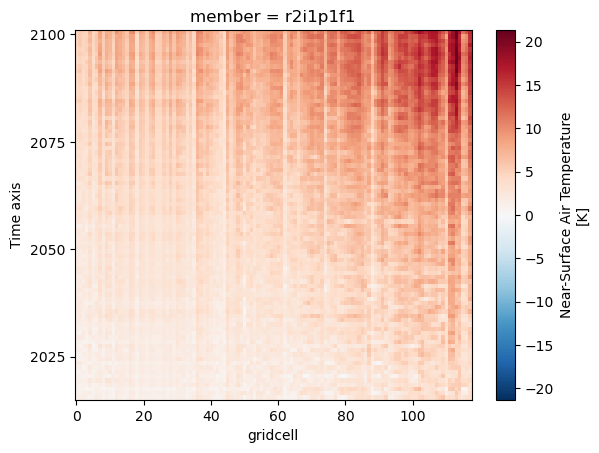

In [21]:
tas_stacked["ssp585"].tas.isel(member=1).plot()

We have now converted the 3D field (with dimensions lat, lon, and time) to a 2D field (with dimensions gridcell and time).

We create a new `DataTree` from all predictors - here the smoothed global mean and it's residuals. We could add more predictors similarly (e.g. the squared temperatures or the ocean heat uptake):

In [22]:
predictors = mesmer.datatree.merge([tas_globmean_smoothed, tas_globmean_resids])

target = tas_stacked.copy()

In the linear regression, we want to weigh the values of the different scnearios equally, i.e. we do not want scenarios with more members (here ssp585) be overrepresented in the linear regression parameters. Thus, we generate weights that weigh each value by the number of members in their scenario, so $w_{scen, mem, ts} = 1 / n\_mem_{scen}$. We do currently not take different number of timesteps (historical vs. scenario) into account:

In [23]:
# create weights
weights = mesmer.weighted.equal_scenario_weights_from_datatree(tas_stacked)
weights

<xarray.DataTree>
Group: /
├── Group: /historical
│       Dimensions:  (time: 165, member: 2)
│       Coordinates:
│         * time     (time) object 1kB 1850-07-01 06:00:00 ... 2014-07-01 06:00:00
│         * member   (member) <U8 64B 'r1i1p1f1' 'r2i1p1f1'
│       Data variables:
│           weights  (time, member) float64 3kB 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
├── Group: /ssp126
│       Dimensions:  (time: 86, member: 1)
│       Coordinates:
│         * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│         * member   (member) <U8 32B 'r1i1p1f1'
│       Data variables:
│           weights  (time, member) float64 688B 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
└── Group: /ssp585
        Dimensions:  (time: 86, member: 2)
        Coordinates:
          * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
          * member   (member) <U8 64B 'r1i1p1f1' 'r2i1p1f1'
        Data variables:
            weights  (time, member) float64 1kB 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5

Now we need stack the different scenarios, ensemble members and timesteps into one sample dimension for the linear regression.We want one array per predictor and the target such that each sample of the predictor variables aligns with the corresponding sample of the target:

In [24]:
# TODO: update after #633
predictors_stacked, target_stacked, weights_stacked = (
    mesmer.core.datatree.broadcast_and_stack_scenarios(predictors, target, weights)
)

target_stacked

<xarray.Dataset> Size: 585kB
Dimensions:   (gridcell: 118, sample: 588)
Coordinates:
    scenario  (sample) object 5kB 'historical' 'historical' ... 'ssp585'
    time      (sample) object 5kB 1850-07-01 06:00:00 ... 2100-07-01 06:00:00
    member    (sample) <U8 19kB 'r1i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1' 'r2i1p1f1'
    lat       (gridcell) float64 944B -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5
    lon       (gridcell) float64 944B 288.0 288.0 18.0 ... 306.0 324.0 342.0
Dimensions without coordinates: gridcell, sample
Data variables:
    tas       (sample, gridcell) float64 555kB -0.1548 -0.1209 ... 13.42 16.16

In [25]:
predictors_stacked

<xarray.Dataset> Size: 38kB
Dimensions:     (sample: 588)
Coordinates:
    scenario    (sample) object 5kB 'historical' 'historical' ... 'ssp585'
    time        (sample) object 5kB 1850-07-01 06:00:00 ... 2100-07-01 06:00:00
    member      (sample) <U8 19kB 'r1i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1'
Dimensions without coordinates: sample
Data variables:
    tas         (sample) float64 5kB 0.088 0.08688 0.08567 ... 6.628 6.713 6.798
    tas_resids  (sample) float64 5kB -0.3034 -0.133 -0.1326 ... -0.04204 0.1266

Now we get the target and predictors in `xr.Dataset`s where the scenario, member and time dimensions are stacked into one sample dimension, i.e. `sample = (scenario, member, time)`. In the linear regression, the predictors for each sample are used for every gridpoint of the target. We can now fit the linear regression:

In [26]:
local_lin_reg = mesmer.stats.LinearRegression()

local_lin_reg.fit(
    predictors=predictors_stacked,
    target=target_stacked.tas,
    dim="sample",
    weights=weights_stacked.weights,
)

local_forced_response_params = local_lin_reg.params
local_forced_response_params

<xarray.Dataset> Size: 38kB
Dimensions:        (gridcell: 118, sample: 588)
Coordinates:
    lat            (gridcell) float64 944B -49.5 -40.5 -31.5 ... 76.5 76.5 76.5
    lon            (gridcell) float64 944B 288.0 288.0 18.0 ... 324.0 342.0
    scenario       (sample) object 5kB 'historical' 'historical' ... 'ssp585'
    time           (sample) object 5kB 1850-07-01 06:00:00 ... 2100-07-01 06:...
    member         (sample) <U8 19kB 'r1i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1'
Dimensions without coordinates: gridcell, sample
Data variables:
    intercept      (gridcell) float64 944B 0.1033 0.02489 ... 0.1346 0.09724
    tas            (gridcell) float64 944B 0.6961 0.8041 0.7246 ... 1.711 2.458
    tas_resids     (gridcell) float64 944B 0.4748 0.4167 0.453 ... 1.675 0.6918
    fit_intercept  bool 1B True
    weights        (sample) float64 5kB 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5

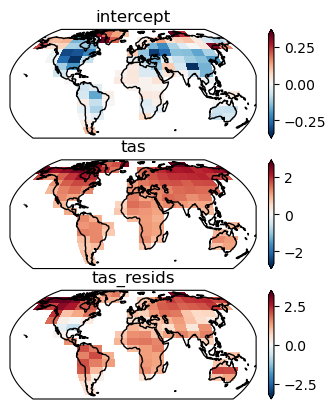

In [27]:
data_vars = (
    "intercept",
    "tas",
    "tas_resids",
)

f, axs = plt.subplots(
    3, 1, sharex=True, sharey=True, subplot_kw={"projection": ccrs.Robinson()}
)
axs = axs.flatten()

for ax, data_var in zip(axs, data_vars):

    da = local_forced_response_params[data_var]
    da = mesmer.grid.unstack_lat_lon_and_align(da, grid_orig)

    h = da.plot(
        ax=ax,
        label=data_var,
        robust=True,
        center=0,
        extend="both",
        add_colorbar=False,
        transform=ccrs.PlateCarree(),
    )

    ax.set_extent((-180, 180, -60, 85), ccrs.PlateCarree())
    cbar = plt.colorbar(h, ax=ax, extend="both", pad=0.025)  # , shrink=0.7)
    ax.set(title=data_var, xlabel="", ylabel="", xticks=[], yticks=[])
    ax.coastlines()

### Local variability
Now we need to fit the parameters for the AR(1) process with a spatially correlated noise term used to emulate local variability:

$\eta_{s,t} = \gamma_{0, s} + \gamma_{1, 2} \cdot \eta_{s, t-1} + \nu_{s,t}, \ \nu_{s,t} \sim \mathcal{N}(0, \Sigma_{\nu}(r))$

The first component that contains the AR parameters $\gamma_{0, s} + \gamma_{1, 2} \cdot \eta_{s, t-1}$ ensures temporal correlation of the local variability whereas the noise term $\nu_{s,t}$ ensures spatial consistency. The covariance matrix $\Sigma_{\nu}(r)$ is estimated on the whole grid and represents the spatial correlation of temperatures at the different gridpoints. 

#### Estimate the AR parameters

First we need to compute the residuals after the linear regression:

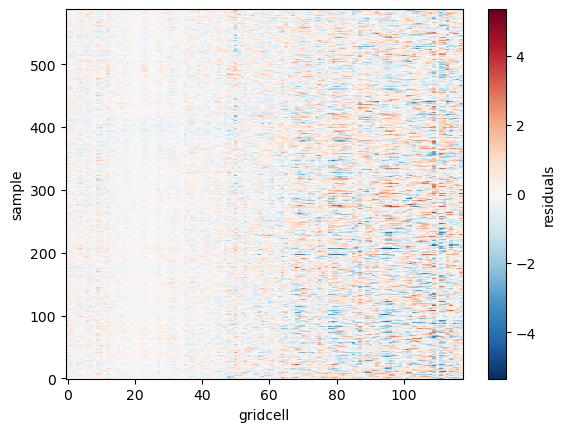

In [28]:
tas_stacked_residuals = local_lin_reg.residuals(
    predictors=predictors_stacked, target=target_stacked.tas
).T

tas_stacked_residuals.T.plot()

# unstack the residuals
tas_un_stacked_residuals = tas_stacked_residuals.set_index(
    sample=("time", "member", "scenario")
).unstack("sample")

In [29]:
# put each scenario into a DataTree node again, get rid of superfluous (nan) time steps and/or members 
# that result from the unstacking
dt_resids = xr.DataTree()
for scenario in tas_un_stacked_residuals.scenario.values:
    dt_resids[scenario] = xr.DataTree(
        tas_un_stacked_residuals.to_dataset()
        .sel(scenario=scenario)
        .dropna("member", how="all")
        .dropna("time")
        .drop_vars("scenario")
    )

In [30]:
# fit the AR(1) process
local_ar = mesmer.stats.fit_auto_regression_scen_ens(
    dt_resids,
    ens_dim="member",
    dim="time",
    lags=1,
)

local_ar

<xarray.Dataset> Size: 6kB
Dimensions:    (gridcell: 118, lags: 1)
Coordinates:
    lat        (gridcell) float64 944B -49.5 -40.5 -31.5 ... 76.5 76.5 76.5
    lon        (gridcell) float64 944B 288.0 288.0 18.0 ... 306.0 324.0 342.0
  * lags       (lags) int64 8B 1
Dimensions without coordinates: gridcell
Data variables:
    intercept  (gridcell) float64 944B 0.005616 -0.004654 ... 0.001157 -0.008397
    coeffs     (gridcell, lags) float64 944B 0.04741 -0.02513 ... 0.1311 0.2302
    variance   (gridcell) float64 944B 0.1496 0.1605 0.1024 ... 0.8005 0.7438
    nobs       (gridcell) float64 944B 111.3 111.3 111.3 ... 111.3 111.3 111.3

#### Estimate covariance matrix
For the covariance matrix of the white noise we first estimate the empirical covariance matrix of the gridcell's values and then localize it using the Gaspari-Cohn function. This function goes to 0 for for distances bigger than the so called localisation radius. This is also called regularization. It ensures that grid points that are further away from each other do not correlate. Such spurious correlations can arise from rank deficient covariance matrices. In our case because we estimate the covariance on data that has more gridcells than timesteps.

The localisation radius is a parameter that needs to be calibrated and we find the best localisation radius by cross-validation of several radii using the negative loglikelihood.

1. Prepare the distance matrix - the distance between the gridpoints in km.

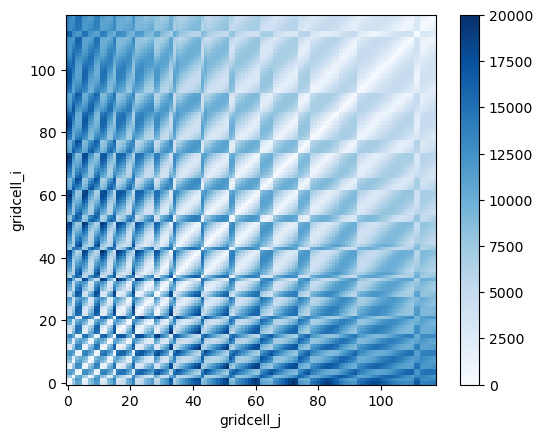

In [31]:
dt = dt_resids["historical"].ds
geodist = mesmer.geospatial.geodist_exact(dt.lon, dt.lat)

# plot
f, ax = plt.subplots()
geodist.plot(ax=ax, cmap="Blues")

ax.set_aspect("equal")

2. prepare the localizer(s) to regularize the covariance matrix

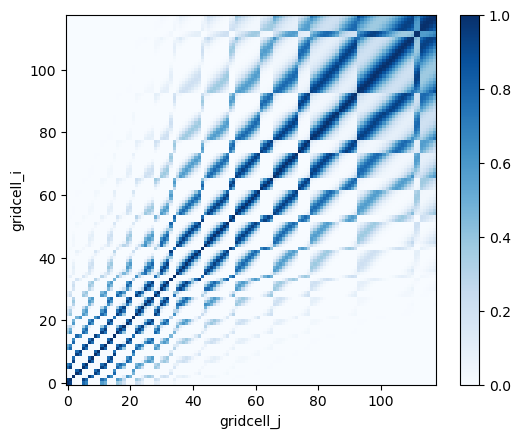

In [32]:
phi_gc_localizer = mesmer.stats.gaspari_cohn_correlation_matrices(
    geodist, range(5_000, 15_001, 500)
)

# plot one
f, ax = plt.subplots()
phi_gc_localizer[5000].plot(ax=ax, cmap="Blues")

ax.set_aspect("equal")

3. Compute the weights

In [33]:
# reusing weights from local trend regression

4. find the best localization radius and localize the empirical covariance matrix

In [34]:
dim = "sample"
k_folds = 15

localized_ecov = mesmer.stats.find_localized_empirical_covariance(
    tas_stacked_residuals, weights_stacked.weights, phi_gc_localizer, dim, k_folds
)

localized_ecov

<xarray.Dataset> Size: 223kB
Dimensions:               (gridcell_i: 118, gridcell_j: 118)
Dimensions without coordinates: gridcell_i, gridcell_j
Data variables:
    localization_radius   int64 8B 12500
    covariance            (gridcell_i, gridcell_j) float64 111kB 0.1585 ... 0...
    localized_covariance  (gridcell_i, gridcell_j) float64 111kB 0.1585 ... 0...

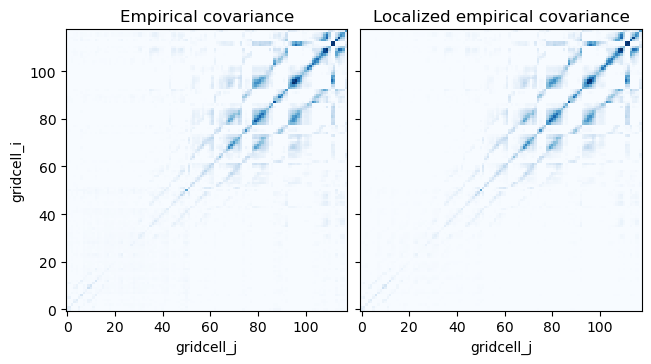

In [35]:
f, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)

opt = dict(vmin=0, vmax=1.5, cmap="Blues", add_colorbar=False)

ax = axs[0]
localized_ecov.covariance.plot(ax=ax, **opt)
ax.set_aspect("equal")
ax.set_title("Empirical covariance")

ax = axs[1]
localized_ecov.localized_covariance.plot(ax=ax, **opt)
ax.set_aspect("equal")
ax.set_title("Localized empirical covariance")
ax.set_ylabel("")
plt.show()

5. Adjust the regularized covariance matrix

Lastly we need to adjust the localized covariance matrix using the AR(1) parameters since the variance of the time series we observe is bigger than the variance of the driving white noise process. Read more about this here: "Statistical Analysis in Climate Research" by Stroch and Zwiers (1999, reprinted 2003).

In [36]:
localized_covariance_adjusted = mesmer.stats.adjust_covariance_ar1(
    localized_ecov.localized_covariance, local_ar.coeffs
)

### Saving the parameters

Finally, we have calibrated all needed parameters and can save them. We can use filefisher to nicely create file names and save the parameters.

In [ ]:
# define path relative to this notebook & create folder
param_path = pathlib.Path("./output/calibrated_parameters/")
param_path.mkdir(exist_ok=True, parents=True)

In [ ]:
PARAM_FILEFINDER = FileFinder(
    path_pattern= param_path,
    file_pattern="params_{module}_{esm}_{scen}.nc",
)

scen_str = "-".join(scenarios)

params = {
    "volcanic": volcanic_params,
    "global-variability": global_ar_params,
    "local-trends": local_lin_reg,
    "local-variability": local_ar,
    "covariance": localized_ecov,
}


save_files = False  # we don't save them here in the example
if save_files:

    for module, param in params.items():

        filename = PARAM_FILEFINDER.create_full_name(
            module=module,
            esm=model,
            scen=scen_str,
        )

        pathlib.Path(filename).parent.mkdir(exist_ok=True)
        param.to_netcdf(filename)

# TODO: save the original grid

## <span style="color:#ff0800">D</span><span style="color:#ffb700">o</span><span style="color:#6df921">n</span><span style="color:#00ffff">e</span><span style="color:#fb00ff">!</span>
When you want to use the calibrated parameters for emulation, see the Tutorials for emulating one or multiple scnearios in the Tutorial section next.